In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random
import os
import re
%matplotlib inline

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
#!pip install scikeras
from sklearn import metrics,linear_model, svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, BayesianRidge, Lasso, RidgeCV, LassoCV, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score, mean_absolute_error, f1_score
import xgboost as xgb

In [8]:
df_348 = pd.read_excel("Results_Mismatch/withDescriptors_DFT_D3_ACS_AMI_348_hetero_Lattice_Mismatch.xlsx",'from_plots')

In [9]:
df_347 = df_348[abs(df_348['MBT_mismatch']) <=4]

In [10]:
X = df_347.iloc[:,21:]
y = df_347['MBT_mismatch']

In [15]:
model_rf = RandomForestRegressor(random_state=42)
# Train model
rf_optuna = model_rf.fit(X_train,y_train)

r2_train_rf = r2_score(y_train, model_rf.predict(X_train).flatten())
r2_test_rf = r2_score(y_test, model_rf.predict(X_test).flatten())

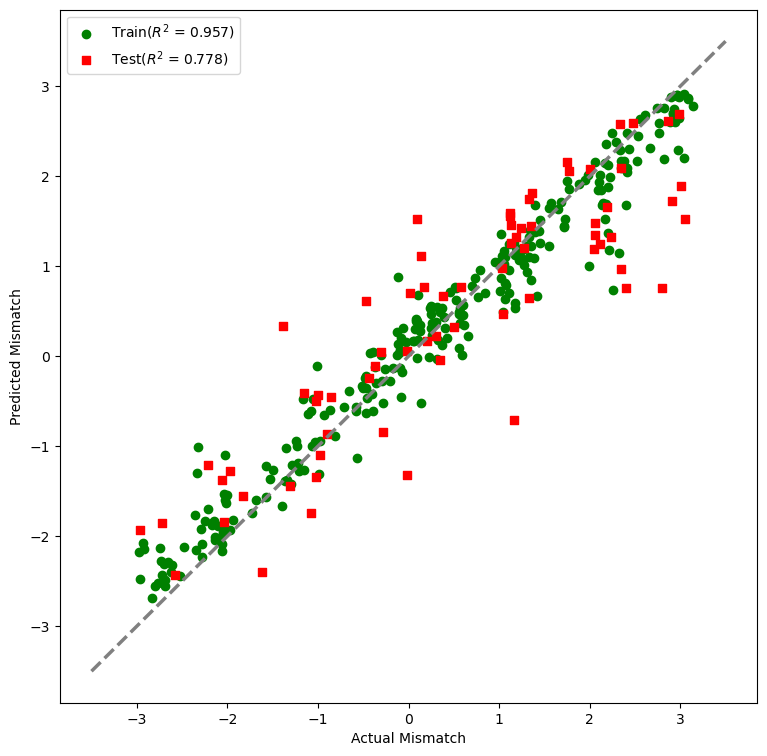

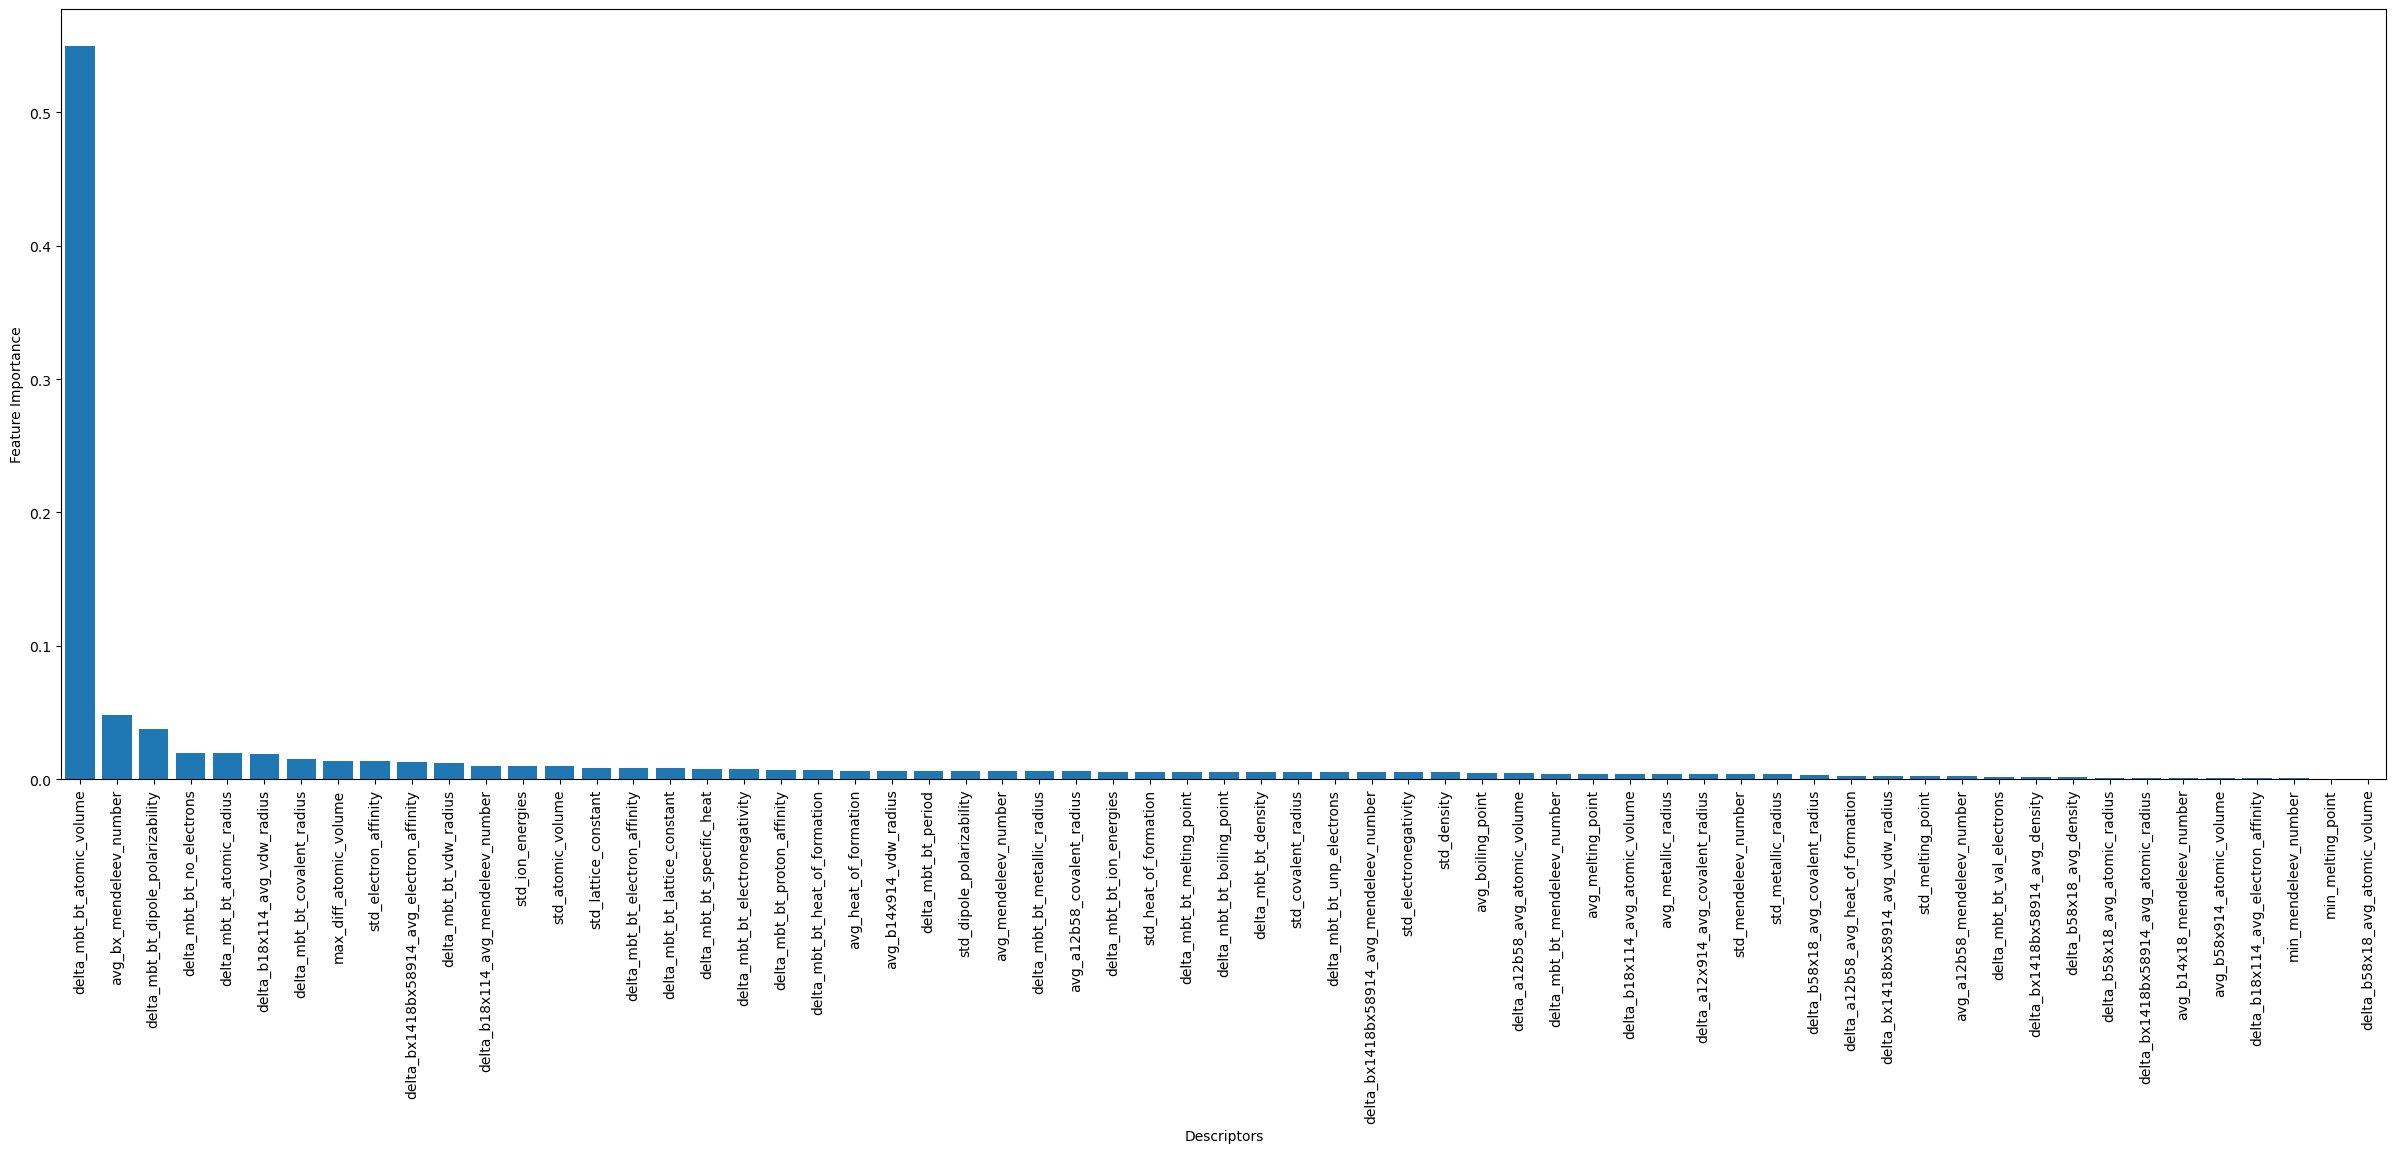

In [24]:
plt.figure(figsize=(9,9))
plt.scatter(y_train, model_rf.predict(X_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_rf:.3f}')+')',marker='o',color='green')
plt.scatter(y_test, model_rf.predict(X_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_rf:.3f}')+')',marker='s',color='red')
plt.xlabel('Actual Mismatch')
plt.ylabel('Predicted Mismatch')
plt.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
plt.bar(range(X.shape[1]), importances_rf[indices_rf], align='center')
desc_labels = X.columns
plt.xticks(range(X.shape[1]), desc_labels[indices_rf],  rotation=90)
plt.xlim([-0.5, X.shape[1]-0.5])
plt.ylabel('Feature Importance')
plt.xlabel('Descriptors')
plt.show()

In [150]:
## Using Optuna and RF

In [46]:
import optuna
import random

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth',5,50)
    max_features = trial.suggest_int('max_features', 1, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    random_state = 42

    model_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,random_state=random_state)
    
    # Train model
    rf_optuna = model_rf.fit(X_train,y_train)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_rf_optuna = cross_val_score(rf_optuna,X_train,y_train,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_rf_optuna = cv_scores_rf_optuna.mean()

    # Return best F1 scores
    r2_train_rf = r2_score(y_train, model_rf.predict(X_train))
    r2_test_rf = r2_score(y_test, model_rf.predict(X_test))
#    return avg_r2_cv_rf_optuna
    return r2_train_rf,avg_r2_cv_rf_optuna,r2_test_rf

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study_rf = optuna.create_study(directions = ['maximize','maximize','maximize']) #(direction='maximize')
study_rf.optimize(objective_rf, n_trials=300)

[I 2025-03-22 11:41:39,885] A new study created in memory with name: no-name-a36f3a22-44de-445c-9fef-a8a2fddbbf8c
[I 2025-03-22 11:41:43,975] Trial 0 finished with values: [0.6254827775422725, 0.46059750538061384, 0.540454007776108] and parameters: {'n_estimators': 87, 'max_depth': 10, 'max_features': 1, 'min_samples_split': 5, 'min_samples_leaf': 6}.
[I 2025-03-22 11:41:46,316] Trial 1 finished with values: [0.6688253866727873, 0.4999756886116768, 0.564578175318958] and parameters: {'n_estimators': 89, 'max_depth': 48, 'max_features': 1, 'min_samples_split': 7, 'min_samples_leaf': 5}.
[I 2025-03-22 11:41:46,476] Trial 2 finished with values: [0.9188856944677126, 0.6878454352379699, 0.7556239288216156] and parameters: {'n_estimators': 31, 'max_depth': 17, 'max_features': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}.
[I 2025-03-22 11:41:46,988] Trial 3 finished with values: [0.8295330150811978, 0.6690986917211874, 0.7394241761130536] and parameters: {'n_estimators': 146, 'max_depth

In [59]:
best_models_rf = study_rf.best_trials
#PRINT('Trial number',
for i in range(len(best_models_rf)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models_rf[i].number, '\nTrain R2:',best_models_rf[i].values[0],'\nValid R2:',best_models_rf[i].values[1],
         '\nTest  R2:',best_models_rf[i].values[2],'\nParams  :',best_models_rf[i].params,'\n=======')

Model No: 0 
Trial No: 66 
Train R2: 0.9524299561929779 
Valid R2: 0.7432049187429471 
Test  R2: 0.7967715105800584 
Params  : {'n_estimators': 115, 'max_depth': 31, 'max_features': 25, 'min_samples_split': 5, 'min_samples_leaf': 1} 
Model No: 1 
Trial No: 159 
Train R2: 0.9524299561929779 
Valid R2: 0.7432049187429471 
Test  R2: 0.7967715105800584 
Params  : {'n_estimators': 115, 'max_depth': 31, 'max_features': 25, 'min_samples_split': 5, 'min_samples_leaf': 1} 
Model No: 2 
Trial No: 207 
Train R2: 0.9561010629075053 
Valid R2: 0.7406085862891663 
Test  R2: 0.7921984667072652 
Params  : {'n_estimators': 88, 'max_depth': 22, 'max_features': 21, 'min_samples_split': 4, 'min_samples_leaf': 1} 
Model No: 3 
Trial No: 255 
Train R2: 0.9524299561929779 
Valid R2: 0.7432049187429471 
Test  R2: 0.7967715105800584 
Params  : {'n_estimators': 115, 'max_depth': 31, 'max_features': 25, 'min_samples_split': 5, 'min_samples_leaf': 1} 
Model No: 4 
Trial No: 269 
Train R2: 0.9620671397810572 
Vali

In [48]:
best_models_rf_pd = pd.DataFrame({'Trial number': [best_models_rf[i].number for i in range(len(best_models_rf))],
                                             'Train R2': [best_models_rf[i].values[0] for i in range(len(best_models_rf))],
                                             'Test R2': [best_models_rf[i].values[2] for i in range(len(best_models_rf))],
                                             'CV R2': [best_models_rf[i].values[1] for i in range(len(best_models_rf))],
                                             'n_estimators': [best_models_rf[i].params['n_estimators'] for i in range(len(best_models_rf))],
                                             'max_depth': [best_models_rf[i].params['max_depth'] for i in range(len(best_models_rf))],
                                             'max_features': [best_models_rf[i].params['max_features'] for i in range(len(best_models_rf))],
                                             'min_samples_split': [best_models_rf[i].params['min_samples_split'] for i in range(len(best_models_rf))],
                                             'min_samples_leaf': [best_models_rf[i].params['min_samples_leaf'] for i in range(len(best_models_rf))]
                                            })
best_models_rf_pd.to_excel('Results_Mismatch/from_plots_RFRegressor_X_HP_Optuna.xlsx')

In [53]:
import optuna
import random

def detailed_objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth',5,50)
    max_features = trial.suggest_int('max_features', 1, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    random_state = 42

    model_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,random_state=random_state)


    
    model_rf = RandomForestRegressor(n_estimators=best_models_rf[5].params['n_estimators'],
                                    max_depth=best_models_rf[5].params['max_depth'],
                                    max_features=best_models_rf[5].params['max_features'],
                                    min_samples_split=best_models_rf[5].params['min_samples_split'],
                                    min_samples_leaf=best_models_rf[5].params['min_samples_leaf'],
                                    random_state=random_state)

    # Train model
    rf_optuna = model_rf.fit(X_train,y_train)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_rf_optuna = cross_val_score(rf_optuna,X_train,y_train,cv=cv,scoring='r2',n_jobs=1)
    avg_r2_cv_rf_optuna = cv_scores_rf_optuna.mean()

    # Return best R2 scores and MAE
    r2_train_rf = r2_score(y_train, model_rf.predict(X_train))
    r2_test_rf = r2_score(y_test, model_rf.predict(X_test))

    mae_train_rf = mean_absolute_error(y_train, model_rf.predict(X_train))
    mae_test_rf = mean_absolute_error(y_test, model_rf.predict(X_test))
    
    print('R2 scores (train, CV, test) = ', r2_train_rf,avg_r2_cv_rf_optuna,r2_test_rf)
    print('MAE values (train, test) = ', mae_train_rf,mae_test_rf) 

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y_train, model_rf.predict(X_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train_rf:.3f}')+')',marker='o',color='green')
    ax1.scatter(y_test, model_rf.predict(X_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test_rf:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Actual Mismatch')
    ax1.set_ylabel('Predicted Mismatch')
    ax1.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()

    importances_rf = model_rf.feature_importances_
    indices_rf = np.argsort(importances_rf)[::-1]    
    ax2.bar(range(12), importances_rf[indices_rf][:12], align='center')
    desc_labels_rf = X_train.columns
    ax2.set_xticks(range(12), desc_labels_rf[indices_rf][:12],  rotation=90)
    ax2.set_xlim([-0.5, 11.5])
    ax2.set_ylabel('Feature Importance')
    ax2.set_xlabel('Descriptors')
    plt.show()

R2 scores (train, CV, test) =  0.9524299561929779 0.7432049187429471 0.7967715105800584
MAE values (train, test) =  0.2776759474783482 0.5617810805063576


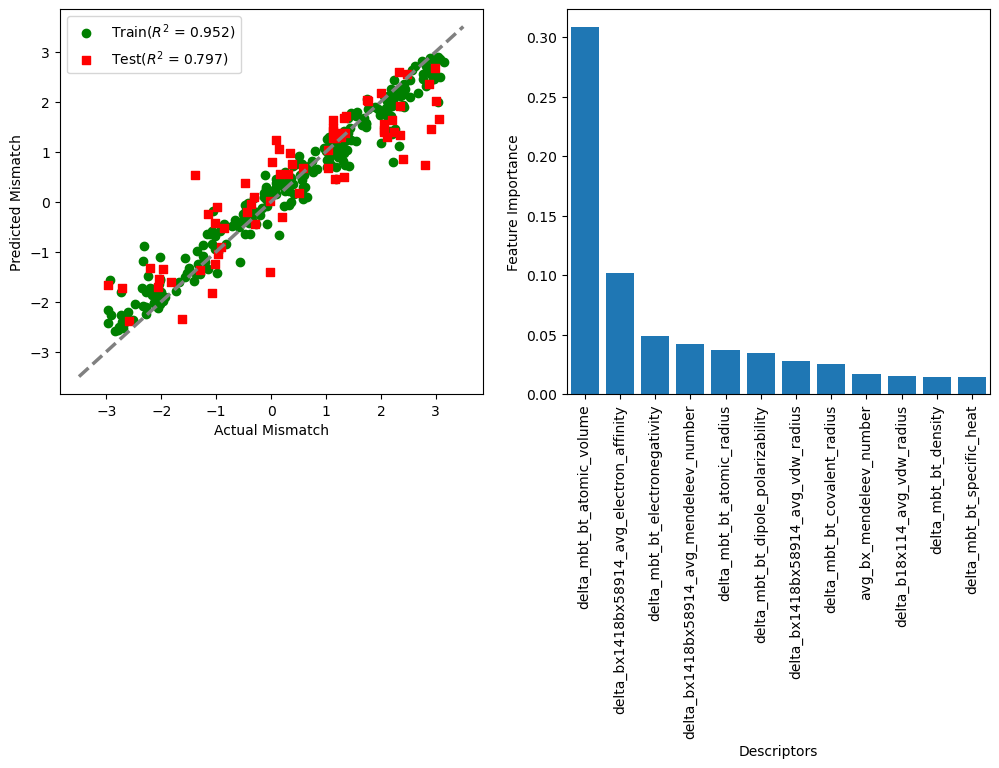

In [54]:
detailed_objective_rf(study_rf.best_trials[0])

R2 scores (train, CV, test) =  0.9524299561929779 0.7432049187429471 0.7967715105800584
MAE values (train, test) =  0.2776759474783482 0.5617810805063576


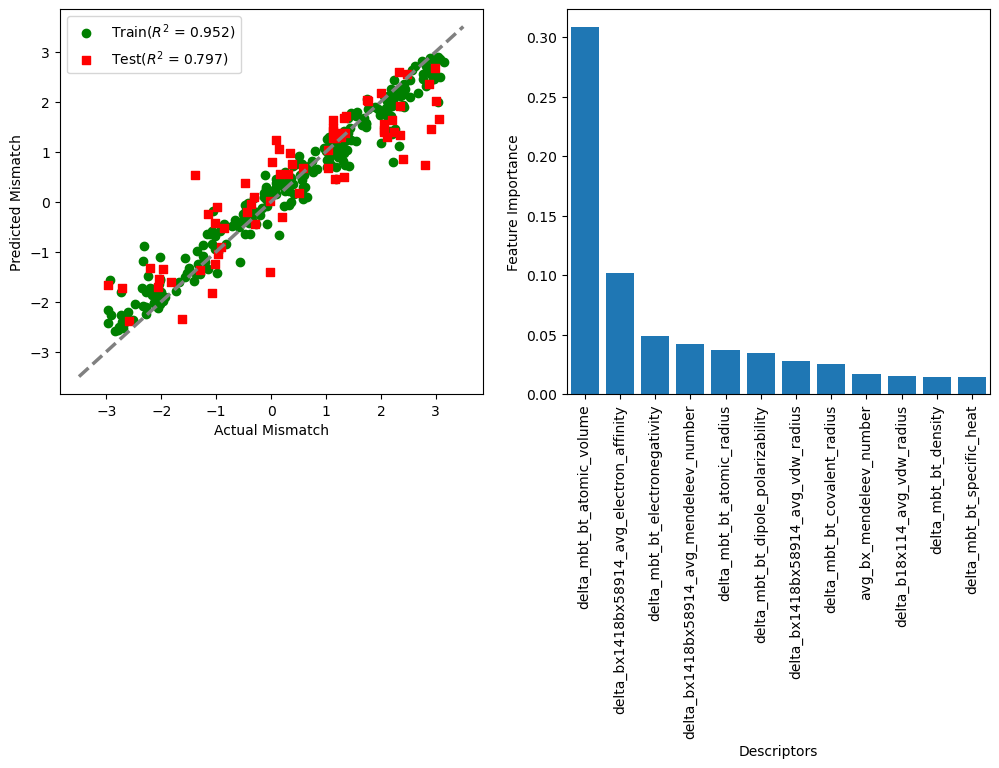

In [55]:
detailed_objective_rf(study_rf.best_trials[5])

In [213]:
## Features elimination

In [58]:
rf_be = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=10,shuffle=True,random_state=42)
n_features = X_train.shape[1]

rf_sfs = sfs(rf_be,forward=False,k_features=(1,n_features),scoring='r2',cv=cv,verbose=2,n_jobs=-1)

rf_sfs = rf_sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   39.3s finished

[2025-03-22 12:03:20] Features: 62/1 -- score: 0.7184554632783832[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   42.2s finished

[2025-03-22 12:04:02] Features: 61/1 -- score: 0.7262282122707938[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   38.4s finished

[2025-03-22 12:04:41] Features: 60/1 -- score: 0.7288049169180396[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  60 o

In [60]:
rf_sfs.get_metric_dict()

{63: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62),
  'cv_scores': array([0.50414852, 0.78940145, 0.80683568, 0.73581701, 0.67484047,
         0.82357459, 0.60269528, 0.83354675, 0.57015381, 0.71489931]),
  'avg_score': 0.7055912875371141,
  'feature_names': ('delta_b18x114_avg_vdw_radius',
   'delta_bx1418bx58914_avg_vdw_radius',
   'avg_b14x914_vdw_radius',
   'std_covalent_radius',
   'delta_b58x18_avg_covalent_radius',
   'delta_a12x914_avg_covalent_radius',
   'avg_a12b58_covalent_radius',
   'delta_b58x18_avg_atomic_radius',
   'delta_bx1418bx58914_avg_atomic_radius',
   'std_atomic_volum

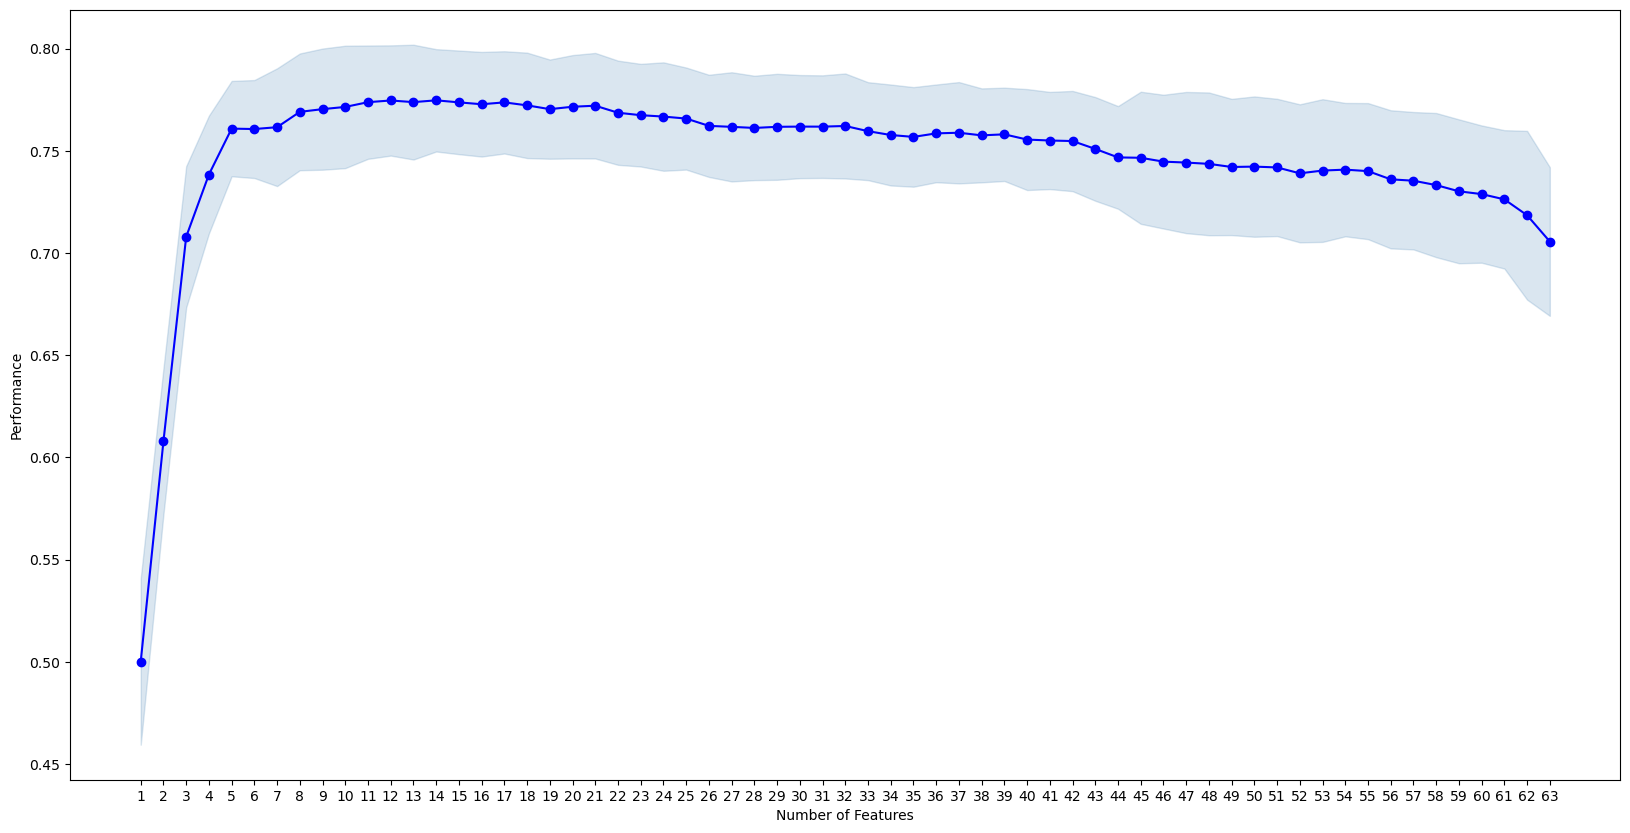

In [101]:
fig = plot_sfs(rf_sfs.get_metric_dict(),kind='std_err',figsize=(20,10))
plt.show()

In [102]:
rf_sfs.k_score_

0.7746765586287754

In [103]:
rf_sfs.k_feature_idx_

(18, 20, 23, 24, 25, 34, 36, 43, 44, 52, 53, 55, 59, 60)

In [104]:
rf_sfs.k_feature_names_

('std_electron_affinity',
 'delta_bx1418bx58914_avg_electron_affinity',
 'delta_bx1418bx58914_avg_density',
 'avg_boiling_point',
 'avg_melting_point',
 'avg_b14x18_mendeleev_number',
 'delta_bx1418bx58914_avg_mendeleev_number',
 'delta_mbt_bt_covalent_radius',
 'delta_mbt_bt_atomic_radius',
 'delta_mbt_bt_electron_affinity',
 'delta_mbt_bt_period',
 'delta_mbt_bt_specific_heat',
 'delta_mbt_bt_proton_affinity',
 'delta_mbt_bt_mendeleev_number')

In [105]:
X_be_rf = X[[i for i in rf_sfs.k_feature_names_]]
X_train_be_rf = X_train[[i for i in rf_sfs.k_feature_names_]]
X_test_be_rf = X_test[[i for i in rf_sfs.k_feature_names_]]

In [106]:
import optuna
import random

X_train_be_rf = X_train[X_be_rf.columns]
X_test_be_rf = X_test[X_be_rf.columns]

def objective_be_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth',5,50)
    max_features = trial.suggest_int('max_features', 1, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    random_state = 42

    model_be_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,random_state=random_state)
    
    # Train model
    be_rf_optuna = model_be_rf.fit(X_train_be_rf,y_train)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_be_rf_optuna = cross_val_score(be_rf_optuna,X_train_be_rf,y_train,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_be_rf_optuna = cv_scores_be_rf_optuna.mean()

    # Return best F1 scores
    r2_train_be_rf = r2_score(y_train, model_be_rf.predict(X_train_be_rf))
    r2_test_be_rf = r2_score(y_test, model_be_rf.predict(X_test_be_rf))
#    return avg_r2_cv_be_rf_optuna
    return r2_train_be_rf,avg_r2_cv_be_rf_optuna,r2_test_be_rf

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study_be_rf = optuna.create_study(directions = ['maximize','maximize','maximize']) #(direction='maximize')
study_be_rf.optimize(objective_be_rf, n_trials=300)

[I 2025-03-22 16:59:31,211] A new study created in memory with name: no-name-5e3bb51f-1613-43d9-a777-d6f45a82968b
[I 2025-03-22 16:59:35,115] Trial 0 finished with values: [0.8724714219930125, 0.7343124916107092, 0.7661729337341611] and parameters: {'n_estimators': 83, 'max_depth': 16, 'max_features': 8, 'min_samples_split': 4, 'min_samples_leaf': 5}.
[I 2025-03-22 16:59:37,603] Trial 1 finished with values: [0.9196280790454862, 0.760650135416065, 0.7923045651041708] and parameters: {'n_estimators': 101, 'max_depth': 47, 'max_features': 19, 'min_samples_split': 6, 'min_samples_leaf': 3}.
[I 2025-03-22 16:59:38,102] Trial 2 finished with values: [0.9544009014111225, 0.7532537456934627, 0.7880123172421161] and parameters: {'n_estimators': 127, 'max_depth': 33, 'max_features': 5, 'min_samples_split': 4, 'min_samples_leaf': 1}.
[I 2025-03-22 16:59:38,345] Trial 3 finished with values: [0.863504274062706, 0.732975801481607, 0.7769707954863291] and parameters: {'n_estimators': 54, 'max_depth

In [107]:
best_models_be_rf = study_be_rf.best_trials
#PRINT('Trial number',
for i in range(len(best_models_be_rf)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models_be_rf[i].number, '\nTrain R2:',best_models_be_rf[i].values[0],'\nValid R2:',best_models_be_rf[i].values[1],
         '\nTest  R2:',best_models_be_rf[i].values[2],'\nParams  :',best_models_be_rf[i].params,'\n=======')

Model No: 0 
Trial No: 122 
Train R2: 0.9668548285887927 
Valid R2: 0.773395755741568 
Test  R2: 0.796954200767593 
Params  : {'n_estimators': 122, 'max_depth': 30, 'max_features': 13, 'min_samples_split': 2, 'min_samples_leaf': 1} 
Model No: 1 
Trial No: 132 
Train R2: 0.9583867550201576 
Valid R2: 0.7724881868599857 
Test  R2: 0.8001206099920051 
Params  : {'n_estimators': 43, 'max_depth': 36, 'max_features': 37, 'min_samples_split': 3, 'min_samples_leaf': 1} 
Model No: 2 
Trial No: 157 
Train R2: 0.9668548285887927 
Valid R2: 0.773395755741568 
Test  R2: 0.796954200767593 
Params  : {'n_estimators': 122, 'max_depth': 36, 'max_features': 13, 'min_samples_split': 2, 'min_samples_leaf': 1} 
Model No: 3 
Trial No: 166 
Train R2: 0.9649941221123914 
Valid R2: 0.7754834803685757 
Test  R2: 0.792095132376549 
Params  : {'n_estimators': 78, 'max_depth': 26, 'max_features': 27, 'min_samples_split': 2, 'min_samples_leaf': 1} 
Model No: 4 
Trial No: 202 
Train R2: 0.9660180227986784 
Valid R2:

In [108]:
best_models_be_rf_pd = pd.DataFrame({'Trial number': [best_models_be_rf[i].number for i in range(len(best_models_be_rf))],
                                             'Train R2': [best_models_be_rf[i].values[0] for i in range(len(best_models_be_rf))],
                                             'Test R2': [best_models_be_rf[i].values[2] for i in range(len(best_models_be_rf))],
                                             'CV R2': [best_models_be_rf[i].values[1] for i in range(len(best_models_be_rf))],
                                             'n_estimators': [best_models_be_rf[i].params['n_estimators'] for i in range(len(best_models_be_rf))],
                                             'max_depth': [best_models_be_rf[i].params['max_depth'] for i in range(len(best_models_be_rf))],
                                             'max_features': [best_models_be_rf[i].params['max_features'] for i in range(len(best_models_be_rf))],
                                             'min_samples_split': [best_models_be_rf[i].params['min_samples_split'] for i in range(len(best_models_be_rf))],
                                             'min_samples_leaf': [best_models_be_rf[i].params['min_samples_leaf'] for i in range(len(best_models_be_rf))]
                                            })
best_models_be_rf_pd.to_excel('Results_Mismatch/from_plots_RFRegressor_X_HP_Optuna_BE.xlsx')

In [115]:
## import optuna
import random

def detailed_objective_be_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth',5,50)
    max_features = trial.suggest_int('max_features', 1, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    random_state = 42

    model_be_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,random_state=random_state)


    
    model_be_rf = RandomForestRegressor(n_estimators=best_models_be_rf[0].params['n_estimators'],
                                    max_depth=best_models_be_rf[0].params['max_depth'],
                                    max_features=best_models_be_rf[0].params['max_features'],
                                    min_samples_split=best_models_be_rf[0].params['min_samples_split'],
                                    min_samples_leaf=best_models_be_rf[0].params['min_samples_leaf'],
                                    random_state=random_state)

    # Train model
    be_rf_optuna = model_be_rf.fit(X_train_be_rf,y_train)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_be_rf_optuna = cross_val_score(be_rf_optuna,X_train_be_rf,y_train,cv=cv,scoring='r2',n_jobs=1)
    avg_r2_cv_be_rf_optuna = cv_scores_be_rf_optuna.mean()

    # Return best R2 scores and MAE
    r2_train_be_rf = r2_score(y_train, model_be_rf.predict(X_train_be_rf))
    r2_test_be_rf = r2_score(y_test, model_be_rf.predict(X_test_be_rf))

    mae_train_be_rf = mean_absolute_error(y_train, model_be_rf.predict(X_train_be_rf))
    mae_test_be_rf = mean_absolute_error(y_test, model_be_rf.predict(X_test_be_rf))
    
    print('R2 scores (train, CV, test) = ', r2_train_be_rf,avg_r2_cv_be_rf_optuna,r2_test_be_rf)
    print('MAE values (train, test) = ', mae_train_be_rf,mae_test_be_rf) 

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y_train, model_be_rf.predict(X_train_be_rf).flatten(),label='Train($R^2$ = '+str(f'{r2_train_be_rf:.3f}')+')',marker='o',color='green')
    ax1.scatter(y_test, model_be_rf.predict(X_test_be_rf).flatten(),label='Test($R^2$ = '+str(f'{r2_test_be_rf:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Actual Mismatch')
    ax1.set_ylabel('Predicted Mismatch')
    ax1.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()

    importances_be_rf = model_be_rf.feature_importances_
    indices_be_rf = np.argsort(importances_be_rf)[::-1]    
    ax2.bar(range(X_train_be_rf.shape[1]), importances_be_rf[indices_be_rf], align='center')
    desc_labels_be_rf = X_train_be_rf.columns
    ax2.set_xticks(range(X_train_be_rf.shape[1]), desc_labels_be_rf[indices_be_rf],  rotation=90)
    ax2.set_xlim([-0.5, X_train_be_rf.shape[1]-0.5])
    ax2.set_ylabel('Feature Importance')
    ax2.set_xlabel('Descriptors')
    plt.show()

In [109]:
# 0,1,7

R2 scores (train, CV, test) =  0.8992440395049005 0.7509660846147596 0.8007607103108977
MAE values (train, test) =  0.38472981491519265 0.5648385276097833


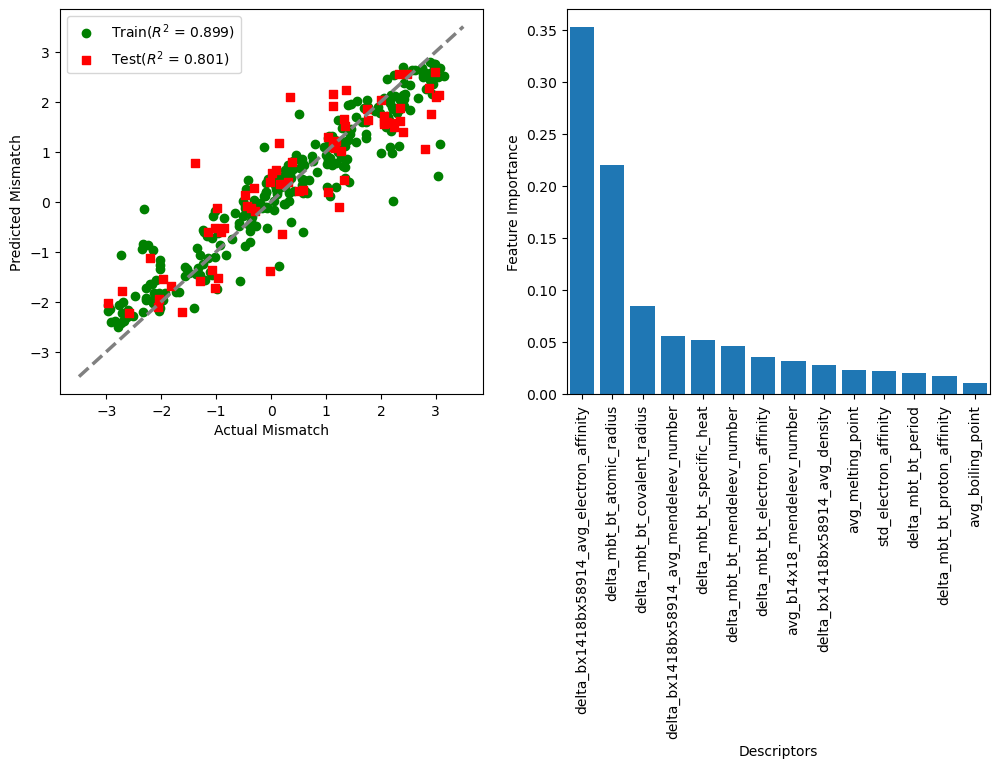

In [111]:
detailed_objective_be_rf(study_be_rf.best_trials[7])

R2 scores (train, CV, test) =  0.9668548285887927 0.773395755741568 0.796954200767593
MAE values (train, test) =  0.22549316788135576 0.5646129096201833


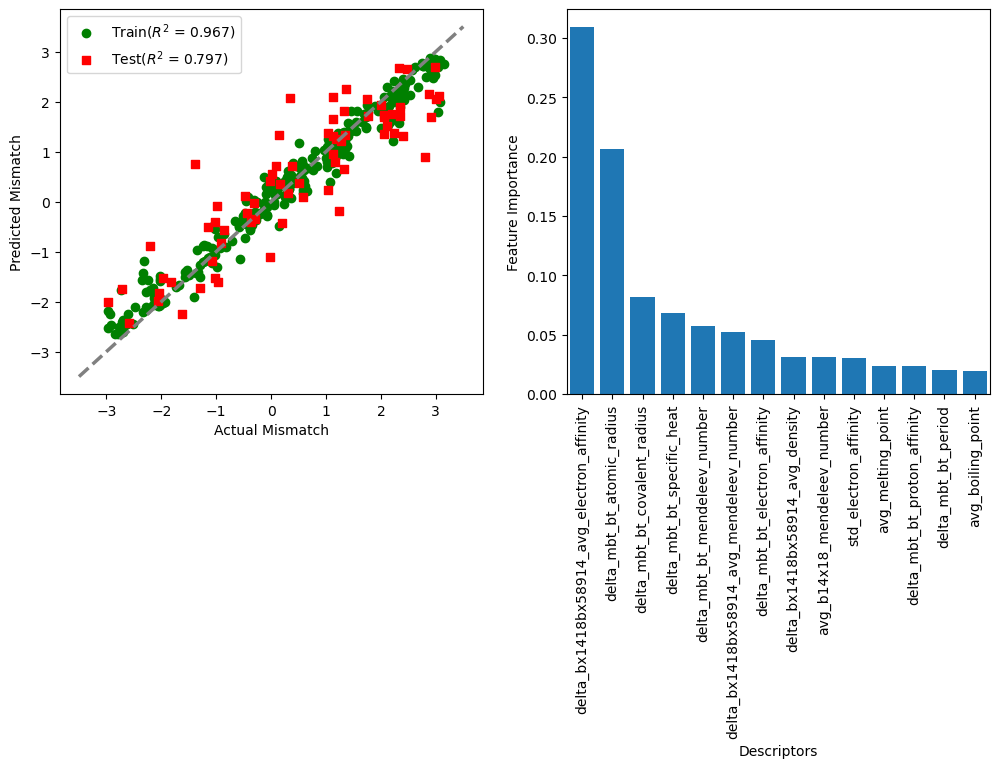

In [116]:
detailed_objective_be_rf(study_be_rf.best_trials[0])

R2 scores (train, CV, test) =  0.9583867550201576 0.7724881868599857 0.8001206099920051
MAE values (train, test) =  0.24361092893785943 0.5682084456286198


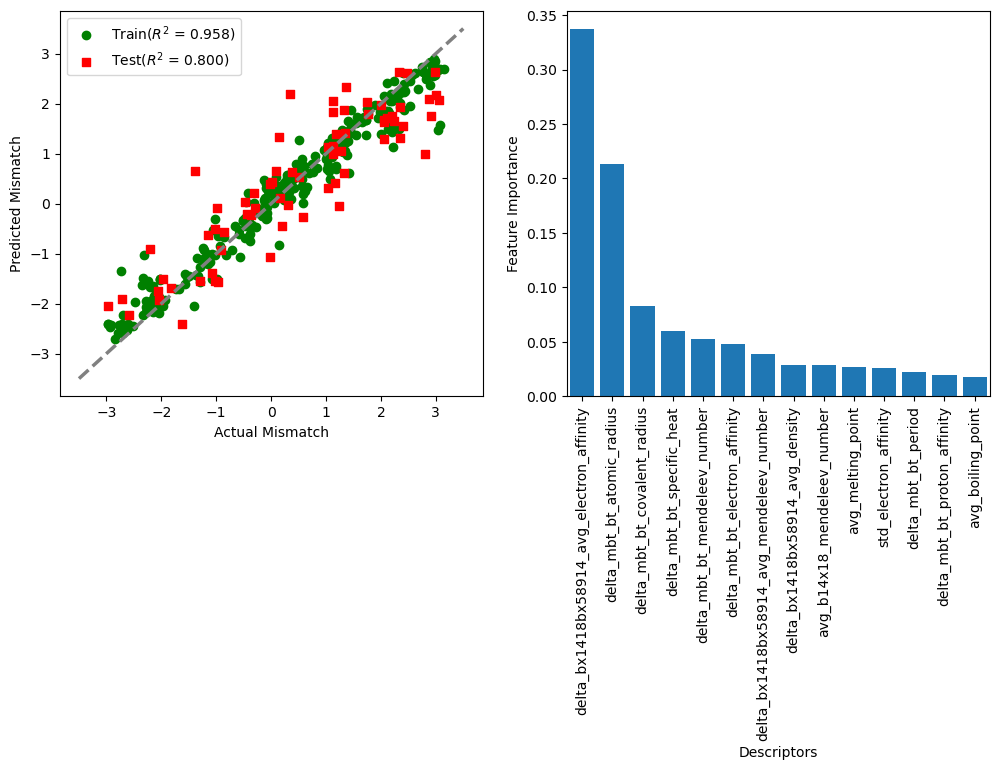

In [114]:
detailed_objective_be_rf(study_be_rf.best_trials[1])

In [261]:
## 1 is the best one

R2 scores (train, CV, test) =  0.9583867550201576 0.7724881868599857 0.8001206099920051
MAE values (train, test) =  0.24361092893785943 0.5682084456286198


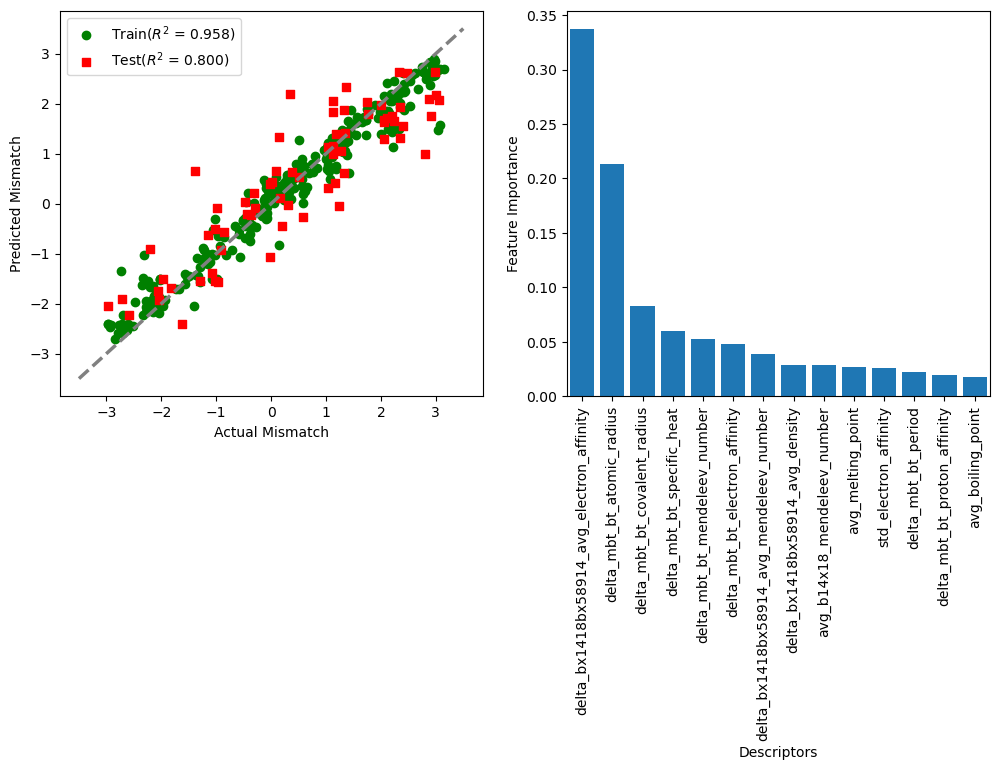

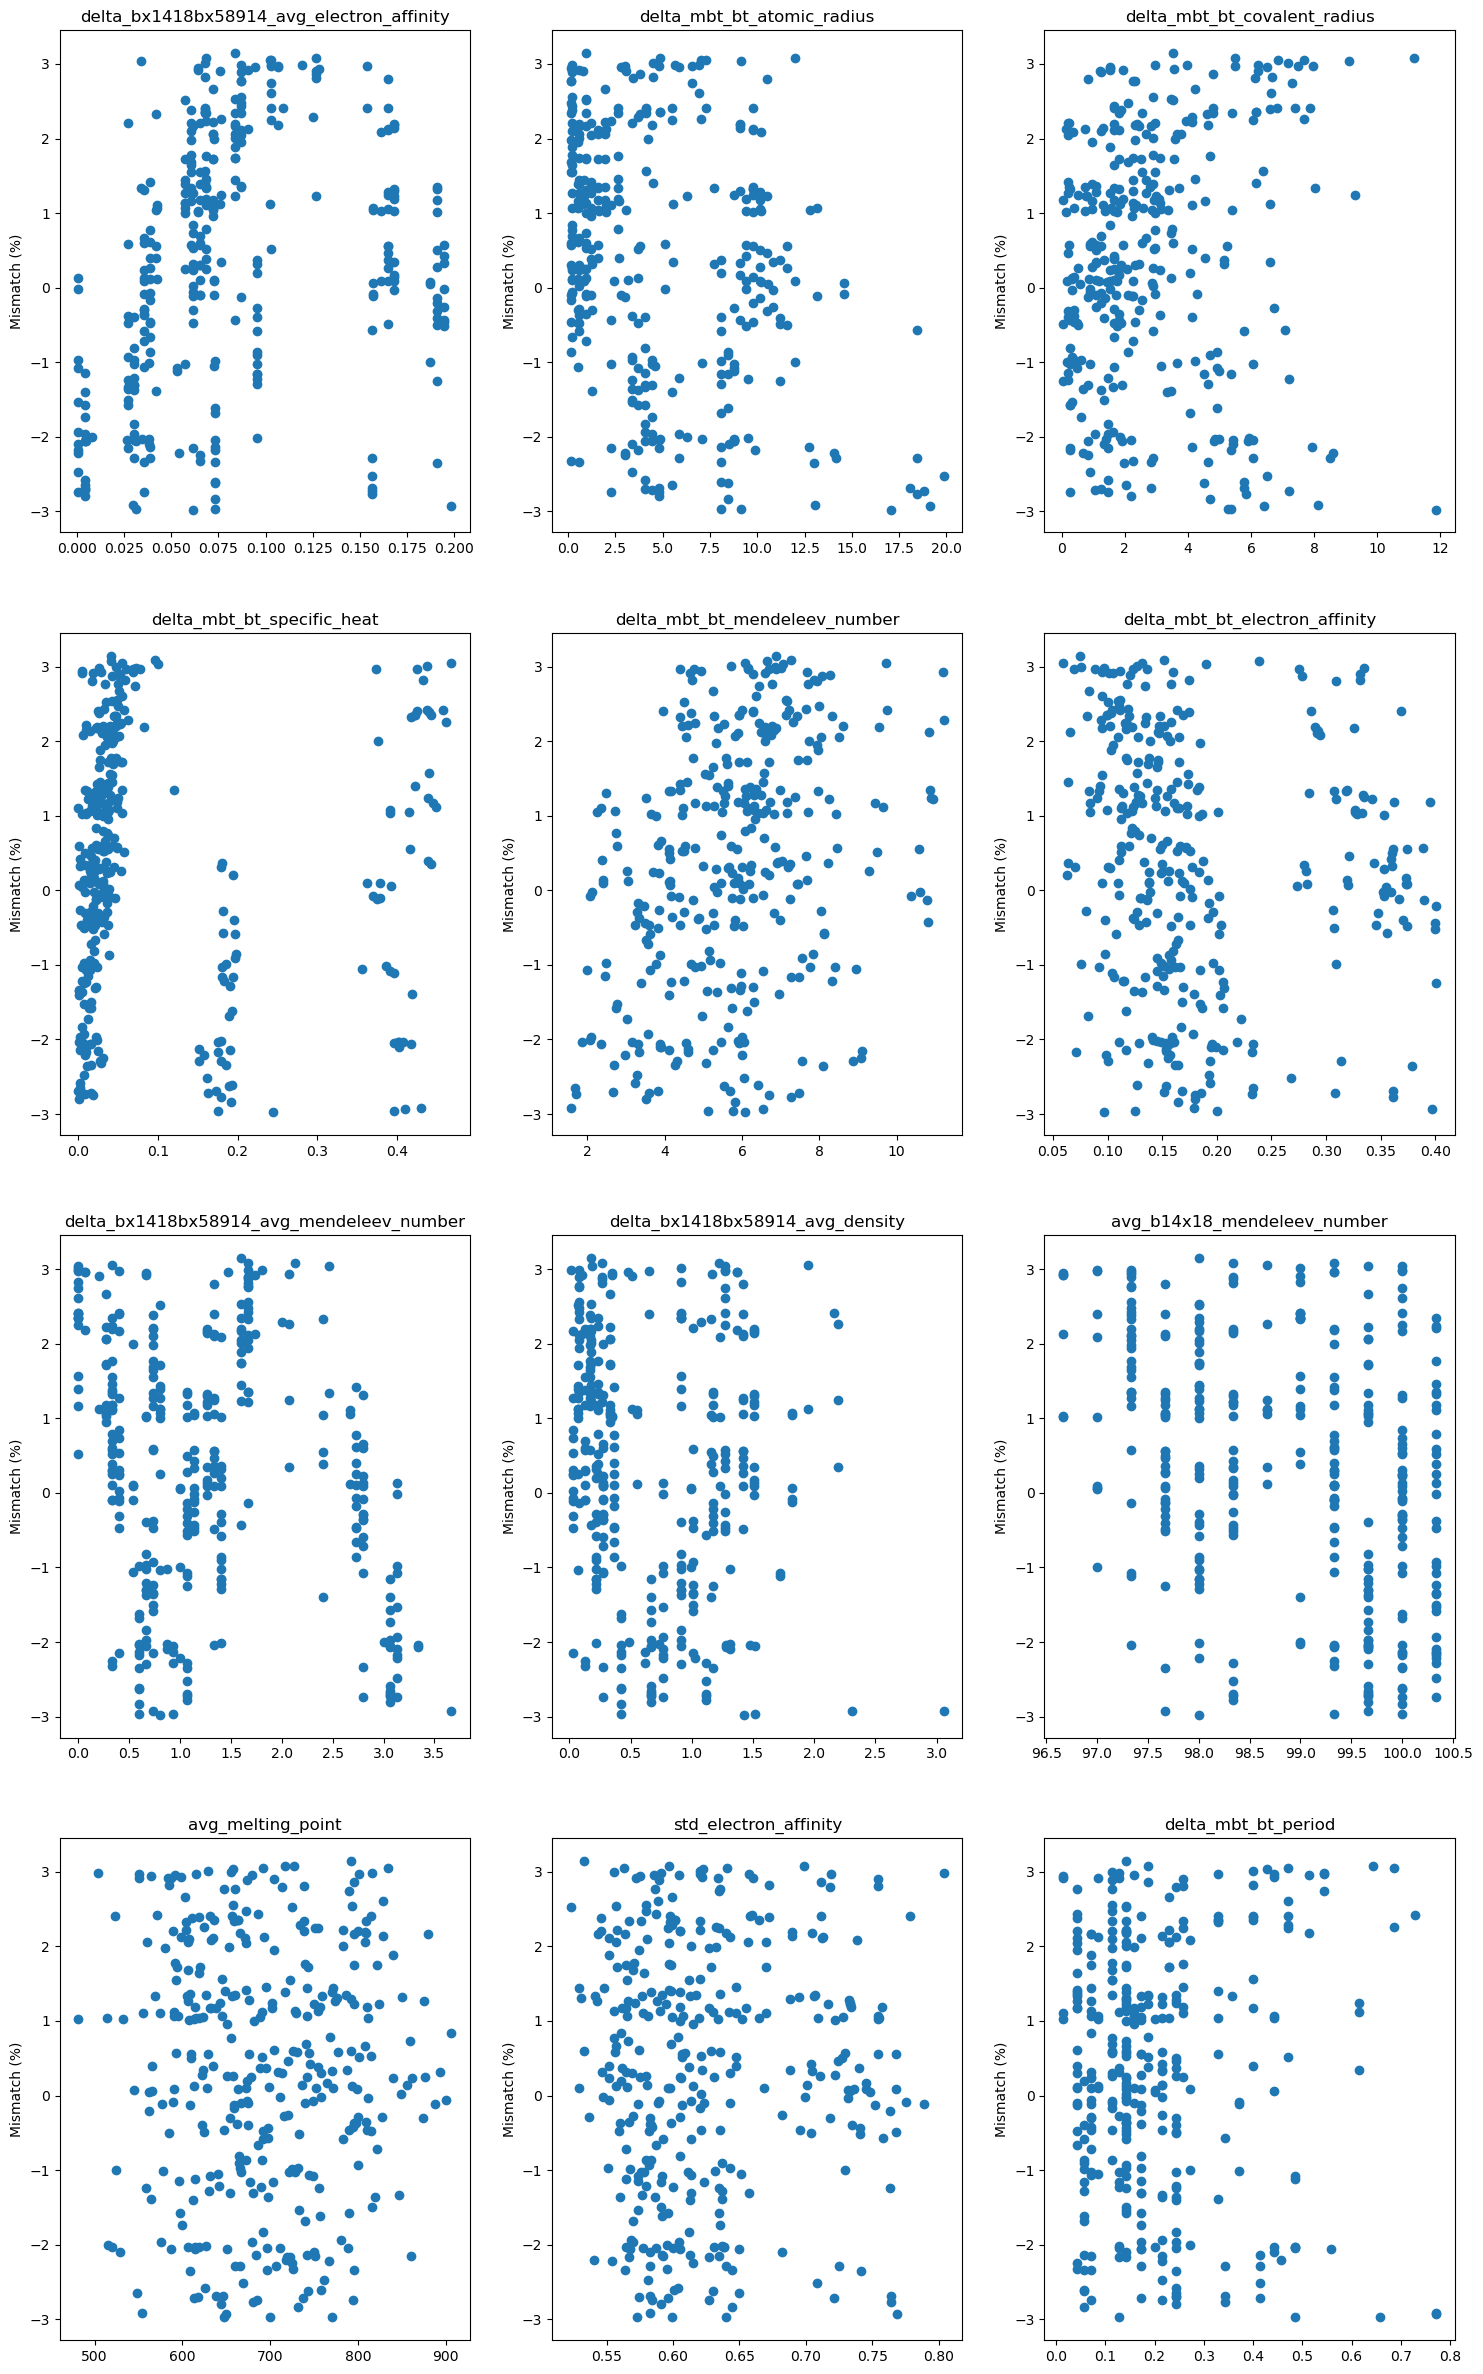

In [122]:
import optuna
import random

def detailed_objective_be_rf_best(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth',5,50)
    max_features = trial.suggest_int('max_features', 1, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    random_state = 42

    model_be_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,random_state=random_state)


    
    model_be_rf = RandomForestRegressor(n_estimators=best_models_be_rf[1].params['n_estimators'],
                                    max_depth=best_models_be_rf[1].params['max_depth'],
                                    max_features=best_models_be_rf[1].params['max_features'],
                                    min_samples_split=best_models_be_rf[1].params['min_samples_split'],
                                    min_samples_leaf=best_models_be_rf[1].params['min_samples_leaf'],
                                    random_state=random_state)

    # Train model
    be_rf_optuna = model_be_rf.fit(X_train_be_rf,y_train)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_be_rf_optuna = cross_val_score(be_rf_optuna,X_train_be_rf,y_train,cv=cv,scoring='r2',n_jobs=1)
    avg_r2_cv_be_rf_optuna = cv_scores_be_rf_optuna.mean()

    # Return best R2 scores and MAE
    r2_train_be_rf = r2_score(y_train, model_be_rf.predict(X_train_be_rf))
    r2_test_be_rf = r2_score(y_test, model_be_rf.predict(X_test_be_rf))

    mae_train_be_rf = mean_absolute_error(y_train, model_be_rf.predict(X_train_be_rf))
    mae_test_be_rf = mean_absolute_error(y_test, model_be_rf.predict(X_test_be_rf))
    
    print('R2 scores (train, CV, test) = ', r2_train_be_rf,avg_r2_cv_be_rf_optuna,r2_test_be_rf)
    print('MAE values (train, test) = ', mae_train_be_rf,mae_test_be_rf) 

    ## Exporting the results
    y_pred_train_be_rf = model_be_rf.predict(X_train_be_rf)
    y_pred_test_be_rf = model_be_rf.predict(X_test_be_rf)

    X_train_be_rf.to_excel('Results_Mismatch/X_train_Optuna_be_rf_from_plots.xlsx',index=False)
    X_test_be_rf.to_excel('Results_Mismatch/X_test_Optuna_be_rf_from_plots.xlsx',index=False)      
    
    y_train.to_excel('Results_Mismatch/y_train_Optuna_be_rf_from_plots.xlsx',index=False)
    y_test.to_excel('Results_Mismatch/y_test_Optuna_be_rf_from_plots.xlsx',index=False)      
    
    pd.DataFrame(y_pred_train_be_rf).to_excel('Results_Mismatch/y_pred_train_Optuna_be_rf_1_from_plots.xlsx',index=False)
    pd.DataFrame(y_pred_test_be_rf).to_excel('Results_Mismatch/y_pred_test_Optuna__be_rf_1_from_plots.xlsx',index=False) 
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y_train, model_be_rf.predict(X_train_be_rf).flatten(),label='Train($R^2$ = '+str(f'{r2_train_be_rf:.3f}')+')',marker='o',color='green')
    ax1.scatter(y_test, model_be_rf.predict(X_test_be_rf).flatten(),label='Test($R^2$ = '+str(f'{r2_test_be_rf:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Actual Mismatch')
    ax1.set_ylabel('Predicted Mismatch')
    ax1.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()

    importances_be_rf = model_be_rf.feature_importances_
    indices_be_rf = np.argsort(importances_be_rf)[::-1]    
    ax2.bar(range(X_train_be_rf.shape[1]), importances_be_rf[indices_be_rf], align='center')
    desc_labels_be_rf = X_train_be_rf.columns
    ax2.set_xticks(range(X_train_be_rf.shape[1]), desc_labels_be_rf[indices_be_rf],  rotation=90)
    ax2.set_xlim([-0.5, X_train_be_rf.shape[1]-0.5])
    ax2.set_ylabel('Feature Importance')
    ax2.set_xlabel('Descriptors')
    plt.show()   

    fig,ax = plt.subplots(nrows = 4, ncols = 3,figsize = (18,30))
    nrows = 4
    ncols = 3
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            
            ax[i,j].scatter(df_347[desc_labels_be_rf[indices_be_rf][count]],df_347['MBT_mismatch'])
            ax[i,j].set_xlabel(''), ax[i,j].set_ylabel('Mismatch (%)'), ax[i,j].set_title(desc_labels_be_rf[indices_be_rf][count])
            
            count = count+1
    
    plt.show()

detailed_objective_be_rf_best(study_be_rf.best_trials[1])

C:\Users\Romakanta\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Romakanta\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Romakanta\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Romakanta\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

R2 scores (train, CV, test) =  0.9578719250576506 0.7746158721229369 0.8007094483823979
MAE values (train, test) =  0.24527440192701835 0.5680672972877961


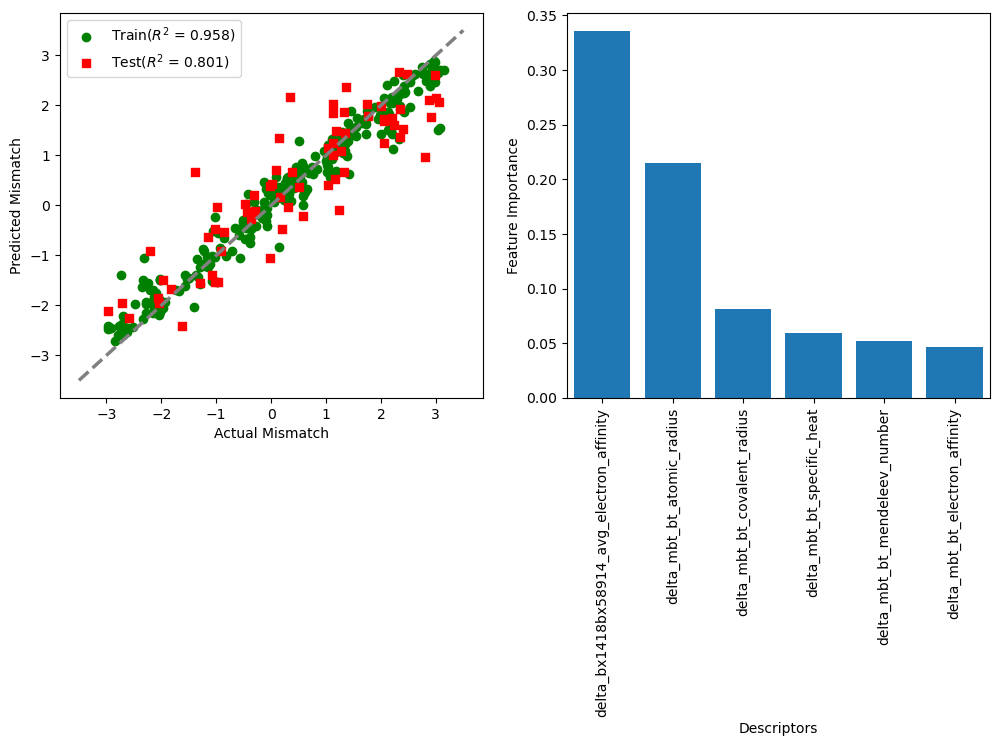

In [16]:
# Trial No: 132 
# Train R2: 0.9583867550201576 
# Valid R2: 0.7724881868599857 
# Test  R2: 0.8001206099920051 
# Params  : {'n_estimators': 43, 'max_depth': 36, 'max_features': 37, 'min_samples_split': 3, 'min_samples_leaf': 1} 

X_train_be_rf = pd.read_excel('Results_Mismatch/X_train_Optuna_be_rf_from_plots.xlsx')
X_test_be_rf = pd.read_excel('Results_Mismatch/X_test_Optuna_be_rf_from_plots.xlsx')      

y_train = pd.read_excel('Results_Mismatch/y_train_Optuna_be_rf_from_plots.xlsx')
y_test = pd.read_excel('Results_Mismatch/y_test_Optuna_be_rf_from_plots.xlsx')    

model_be_rf_best = RandomForestRegressor(n_estimators=43,max_depth=36,max_features=37,min_samples_split=3,min_samples_leaf=1,random_state=42)
# Train model
be_rf_optuna_best = model_be_rf_best.fit(X_train_be_rf,y_train)
cv = KFold(n_splits=10,shuffle=True,random_state=42)
cv_scores_be_rf_optuna = cross_val_score(be_rf_optuna_best,X_train_be_rf,y_train,cv=cv,scoring='r2',n_jobs=1)
avg_r2_cv_be_rf_optuna = cv_scores_be_rf_optuna.mean()
# Return best R2 scores and MAE
r2_train_be_rf = r2_score(y_train, model_be_rf_best.predict(X_train_be_rf))
r2_test_be_rf = r2_score(y_test, model_be_rf_best.predict(X_test_be_rf))
mae_train_be_rf = mean_absolute_error(y_train, model_be_rf_best.predict(X_train_be_rf))
mae_test_be_rf = mean_absolute_error(y_test, model_be_rf_best.predict(X_test_be_rf))

print('R2 scores (train, CV, test) = ', r2_train_be_rf,avg_r2_cv_be_rf_optuna,r2_test_be_rf)
print('MAE values (train, test) = ', mae_train_be_rf,mae_test_be_rf) 
## Exporting the results
y_pred_train_be_rf = model_be_rf_best.predict(X_train_be_rf)
y_pred_test_be_rf = model_be_rf_best.predict(X_test_be_rf)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(y_train, model_be_rf_best.predict(X_train_be_rf).flatten(),label='Train($R^2$ = '+str(f'{r2_train_be_rf:.3f}')+')',marker='o',color='green')
ax1.scatter(y_test, model_be_rf_best.predict(X_test_be_rf).flatten(),label='Test($R^2$ = '+str(f'{r2_test_be_rf:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Actual Mismatch')
ax1.set_ylabel('Predicted Mismatch')
ax1.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()
importances_be_rf_best = model_be_rf_best.feature_importances_
indices_be_rf = np.argsort(importances_be_rf_best)[::-1]    
ax2.bar(range(6), importances_be_rf_best[indices_be_rf][:6], align='center')
desc_labels_be_rf = X_train_be_rf.columns
ax2.set_xticks(range(6), desc_labels_be_rf[indices_be_rf][:6],  rotation=90)
ax2.set_xlim([-0.5, 5.5])
ax2.set_ylabel('Feature Importance')
ax2.set_xlabel('Descriptors')
plt.show()

In [265]:
## predict the lattice mismatch

In [123]:
X_train_be_rf.columns

Index(['std_electron_affinity', 'delta_bx1418bx58914_avg_electron_affinity',
       'delta_bx1418bx58914_avg_density', 'avg_boiling_point',
       'avg_melting_point', 'avg_b14x18_mendeleev_number',
       'delta_bx1418bx58914_avg_mendeleev_number',
       'delta_mbt_bt_covalent_radius', 'delta_mbt_bt_atomic_radius',
       'delta_mbt_bt_electron_affinity', 'delta_mbt_bt_period',
       'delta_mbt_bt_specific_heat', 'delta_mbt_bt_proton_affinity',
       'delta_mbt_bt_mendeleev_number'],
      dtype='object')

In [129]:
candidates_785 = pd.read_excel('Results_Mismatch/descriptors_for_891_candidates.xlsx','without_Si')
X_with_best_features_be_785_rf = candidates_785[X_train_be_rf.columns]
y_785 = candidates_785['MBT_mismatch']

In [130]:
X_with_BE_features

std_electron_affinity  delta_bx1418bx58914_avg_electron_affinity  \
0                 0.620920                                   0.061658   
1                 0.699245                                   0.194521   
2                 0.547252                                   0.000686   
3                 0.731566                                   0.168094   
4                 0.551905                                   0.061658   
..                     ...                                        ...   
780               0.578573                                   0.073237   
781               0.530491                                   0.027378   
782               0.599121                                   0.073237   
783               0.609689                                   0.000686   
784               0.606635                                   0.038551   

     delta_bx1418bx58914_avg_density  avg_boiling_point  avg_melting_point  \
0                           0.029867        1550.233333         849.406833   
1                           1.267333        1769.150000         675.791167   
2                           0.764000        1717.108333         627.063667   
3                           1.510133        1609.525000         811.170833   
4                           0.029867        1661.900000         900.698500   
..                               ...                ...                ...   
780                         0.420067        1582.316667         660.162500   
781                         0.783467        1828.275000         360.758333   
782                         0.420067        1562.358333         646.829167   
783                         0.764000        1745.191667         651.197833   
784                         0.367533        1593.483333         288.725500   

     avg_b14x18_mendeleev_number  delta_bx1418bx58914_avg_mendeleev_number  \
0                     100.000000                                  0.400000   
1                      98.333333                                  1.133333   
2                     100.333333                                  3.133333   
3                      98.333333                                  1.266667   
4                     100.000000                                  0.400000   
..                           ...                                       ...   
780                   100.000000                                  0.600000   
781                    98.000000                                  1.400000   
782                   100.000000                                  0.600000   
783                   100.333333                                  3.133333   
784                    99.333333                                  2.733333   

     delta_mbt_bt_covalent_radius  delta_mbt_bt_atomic_radius  \
0                        2.885714                    0.571429   
1                        1.528571                    9.428571   
2                        0.900000                    5.142857   
3                        0.328571                   10.857143   
4                        0.885714                    0.214286   
..                            ...                         ...   
780                      6.714286                    8.785714   
781                      8.614286                   14.071429   
782                      5.357143                    8.071429   
783                      2.328571                    5.142857   
784                      0.828571                    3.000000   

     delta_mbt_bt_electron_affinity  delta_mbt_bt_period  \
0                          0.175854             0.142857   
1                          0.351639             0.142857   
2                          0.138891             0.214286   
3                          0.359356             0.142857   
4                          0.110325             0.071429   
..                              ...                  ...   
780                        0.098746             0.128

R2 scores (train, CV, test) =  0.9583867550201576 0.7724881868599857 0.8001206099920051


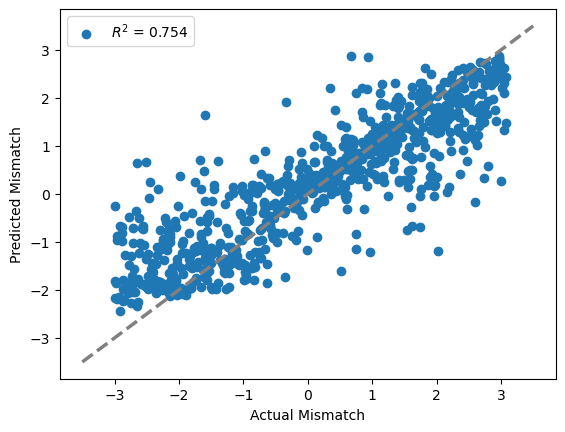

In [131]:
import optuna
import random

def detailed_objective_be_rf_final_pred(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth',5,50)
    max_features = trial.suggest_int('max_features', 1, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    random_state = 42

    model_be_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,random_state=random_state)


    
    model_be_rf = RandomForestRegressor(n_estimators=best_models_be_rf[1].params['n_estimators'],
                                    max_depth=best_models_be_rf[1].params['max_depth'],
                                    max_features=best_models_be_rf[1].params['max_features'],
                                    min_samples_split=best_models_be_rf[1].params['min_samples_split'],
                                    min_samples_leaf=best_models_be_rf[1].params['min_samples_leaf'],
                                    random_state=random_state)

    # Train model
    be_rf_optuna = model_be_rf.fit(X_train_be_rf,y_train)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_be_rf_optuna = cross_val_score(be_rf_optuna,X_train_be_rf,y_train,cv=cv,scoring='r2',n_jobs=1)
    avg_r2_cv_be_rf_optuna = cv_scores_be_rf_optuna.mean()

    # Return best R2 scores and MAE
    r2_train_be_rf = r2_score(y_train, model_be_rf.predict(X_train_be_rf))
    r2_test_be_rf = r2_score(y_test, model_be_rf.predict(X_test_be_rf))
    
    print('R2 scores (train, CV, test) = ', r2_train_be_rf,avg_r2_cv_be_rf_optuna,r2_test_be_rf)

    ## Exporting the final results
    y_pred_be_rf_final = model_be_rf.predict(X_with_best_features_be_785_rf)
    
    y_785.to_csv('Results_Mismatch/y_be_rf_final_lattice_mismatch_from_plots.csv',index=False)
    pd.DataFrame(y_pred_be_rf_final).to_csv('Results_Mismatch/y_pred_be_rf_final_lattice_mismatch_from_plots.csv',index=False)

    plt.scatter(y_785, y_pred_be_rf_final,label='$R^2$ = '+str(f'{metrics.r2_score(y_785, y_pred_be_rf_final):.3f}'))
    plt.xlabel('Actual Mismatch')
    plt.ylabel('Predicted Mismatch')
    plt.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
    plt.legend()
    plt.show()

detailed_objective_be_rf_final_pred(study_be_rf.best_trials[1])